# Training the Steganography Model 
 


In [4]:
!pip install -q --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
!pip install -q matplotlib
!pip install -q tqdm


In [30]:
# imports

import zipfile
from PIL import Image
import matplotlib.pyplot as plt


## Importing the data  

In [6]:
# Añadir rutas de los inputs de nuestro DRIVE

PATH_DATA = '/Users/vera/RoboticsClub/steganography/steganography-workshop/steganography-workshop/data'
PATH_IMAGES = f'{PATH_DATA}/images/JPEGImages.zip'

### Step 1 

EDA to see the iamges



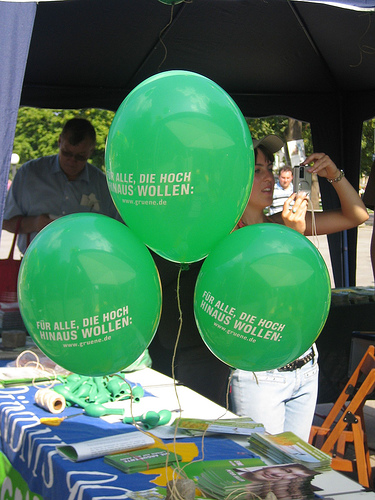

In [7]:
%matplotlib inline

# Accing the zip file
archive = zipfile.ZipFile(f'{PATH_IMAGES}', 'r')
# Lets look at an image
imgfile = archive.open('JPEGImages/2012_004330.jpg')
Image.open(imgfile)

###  



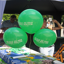

In [8]:
SIZE_IMAGE = 64 # we want to have all our images in 64x64 size
WIDTH = SIZE_IMAGE
HEIGHT = SIZE_IMAGE

def open_image_and_resize(image, width, height):
  # change the dimensions using .resize()
  img = Image.open(image)
  newsize = (width, height)
  image_resized = img.resize(newsize)
  return image_resized


img_resized = open_image_and_resize(imgfile, WIDTH, HEIGHT)
# lets see the new image
img_resized

## Models in Pytorch
 

### Dataset Class in Pytorch
 

In PyTorch, a dataset is typically used to represent a collection of training or testing data, and it is often necessary to process this data in a specific way before using it to train a model. To facilitate this process, PyTorch provides a dataset class that can be used to encapsulate the data and provide a set of methods for processing it.

Using a dataset class has several benefits when building a PyTorch model. Firstly, it allows for efficient data loading, as the dataset class can be used to load data in batches, which can significantly reduce the time it takes to train a model. Secondly, it provides a standardized interface for processing the data, which makes it easier to write reusable code and to collaborate with other developers.

Another benefit of using a dataset class is that it allows for data augmentation, which is a technique that can be used to increase the size of the dataset by generating new data based on the existing data. This can be useful for improving the accuracy of a model, especially when dealing with small datasets.

In [11]:
# imports 
import os
import csv
import torch
import numpy as np
from contextlib import contextmanager
from torchvision import datasets, transforms

class _ImageZipDataset(torch.utils.data.Dataset): 
    def __init__(self, zip_file, samples, archive, transform=None, target_transform=None):
        self.zip_file = zip_file
        self.archive = archive
        self.samples = samples
        self.transform = transform
        self.target_transform = target_transform
        print(self.archive)

    def __getitem__(self, index): 
        """
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        print(f"path_image: {path} y {target}")
        sample = Image.open(self.archive.open(path)).convert('RGB')
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

    def __len__(self):
        """
        Returns:
            int: length of the dataset 
        """
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

class ImageZipDatasetWrapper(torch.utils.data.Dataset):
    """
    A dataset where images are stored in a zip file:
    <filename>.zip@/<img_1>.JPEG
    <filename>.zip@/<img_2>.JPEG
    <filename>.zip@/<img_3>.JPEG
    ...
    And the class assignments are stored in a TSV file: # a tsv file is a file with tab separated values for each row
    .../<filename>.zip@<img_1>.JPEG    <class_a>
    .../<filename>.zip@<img_2>.JPEG    <class_b>
    .../<filename>.zip@<img_3>.JPEG    <class_c>
    Args:
        zip_path (string): path to zip file
        transform (callable, optional): transforms to apply to each image
        target_transform (callable, optional): transforms to apply to each target
    """

    def __init__(self, zip_path, transform=None, target_transform=None, n_samples=14000):
        if not os.path.exists(zip_path):
            raise RuntimeError('%s does not exist' % zip_path)

        self.zip_path = zip_path
        self.transform = transform
        self.target_transform = target_transform

        self.archive = zipfile.ZipFile(f'{zip_path}', 'r')
        self.samples = []
        for image_path in archive.namelist()[1:]:
          self.samples.append(archive.open(image_path))
        if transform:
          convert_tensor = transforms.ToTensor()  
          self.data = [np.array(open_image_and_resize(x, WIDTH, HEIGHT)).astype(np.uint8) for x in self.samples[0:n_samples]]
          self.data = np.array(self.data)
        print(self.archive)

    @contextmanager
    def dataset(self):
        with ZipFile(self.zip_path, 'r') as zip_file:
            res = _ImageZipDataset(
                zip_file=zip_file,
                archive=self.archive,
                samples=self.samples,
                transform=self.transform,
                target_transform=self.target_transform,
            )
            yield res

    def __len__(self):
        return len(self.samples)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Zip Location: {}\n'.format(self.zip_path)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

Define the transforms for the data. We need to convert the data to a tensor and normalize it.

In [12]:
N_SAMPLES = 14000 #By default trained with 14000 samples

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0., 0., 0.), (255, 255, 255)),
                               transforms.Resize((300, 300))])

# Download and load the training data
trainset = ImageZipDatasetWrapper(f'{PATH_IMAGES}', transform=transform, n_samples=N_SAMPLES)

<zipfile.ZipFile filename='/Users/vera/RoboticsClub/steganography/steganography-workshop/steganography-workshop/data/images/JPEGImages.zip' mode='r'>


Visualize Data

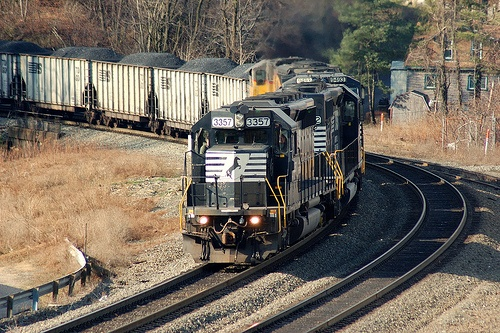

In [13]:
sample_image = trainset.samples[0]
Image.open(sample_image).convert('RGB')

#### Divide the Dataset 

The way we input the images into the model is as follows: 
1. Payload: This is the secret message we want to hide inside the cover image.
2. Source: This is the cover image that will contain the payload. 

This means we need to divide the dataset into those two image labels. 

The next function takes in three arguments: the train_set, which contains the training data, the number of samples to use (n_samples), and a dictionary of mapping keys (mapping_keys). The mapping keys are used to map the source data to a specific set of values that can be used to encode the payload data.

The function first converts the input tensors to numpy arrays, and then creates two copies of the source data: train_x_source and train_x_payload. The train_x_payload is created by opening and resizing the images specified by the first n_samples in the training set, converting them to grayscale (using 'L' mode), and then converting them to a numpy array of unsigned 8-bit integers (np.uint8).

Next, the function creates two boolean masks using np.in1d and np.logical_not to split the source data and payload data based on their corresponding mapping keys. The source data is obtained using the source_mask, which is the boolean mask of the source data, and the payload data is obtained using the payload_mask, which is the logical negation of the source mask.

Finally, the function returns the source_data and payload_data numpy arrays, which contain the source and payload data respectively, for use in steganography.



In [14]:
import logging as log

In [15]:
# initialize logger 
log.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p', level=log.INFO)

In [16]:
# Creating mapping for source and payload images
mapping = {key: key + 1 for key in np.arange(0, len(trainset.data), 2)} 
# Mapping the source and payload images in order to encode the payload data in the source images
log.info(f'Mapping: {mapping}')
def get_source_payload_data (train_set, n_samples, mapping_keys):
  """
  Args: 
    train_set (torch.utils.data.Dataset): Dataset to split
    n_samples (int): Number of samples to split
    mapping_keys (dict): Mapping of source and payload images. The mapping keys are used to map the source data to a specific set of values that can be used to encode the payload data.
  
  Returns:
    source_data (np.array): Source data
    payload_data (np.array): Payload data

  """
  # Converting tensors to numpy arrays
  train_x = train_set.data
  train_y = np.array(range(0, n_samples))

  log.info('Converting tensors to numpy arrays')


  train_x_source = train_set.data
  train_x_payload = [np.array(open_image_and_resize(x, WIDTH, HEIGHT).convert('L')).astype(np.uint8) for x in trainset.samples[0:n_samples]] # Resize, Converting to grayscale, convert data into unsigned 8-bit integers (np.uint8) 
  train_x_payload = np.array(train_x_payload) # Converting to numpy array 

  log.info('Converting payload data to grayscale')
  log.info(f'Payload data shape: {train_x_payload.shape}')
  log.info(f'Source data shape: {train_x_source.shape}')
  log.info(f'Payload data type: {train_x_payload.dtype}')
  log.info(f'Source data type: {train_x_source.dtype}')

  # Creating masks for source and payload data
  # two boolean masks using np.in1d and np.logical_not to split the source data and payload data based on their corresponding mapping keys. The source data is obtained using the source_mask, which is the boolean mask of the source data, 
  # and the payload data is obtained using the payload_mask, which is the logical negation of the source mask
  log.info('Creating the masks')
  source_mask = np.in1d(train_y, list(mapping_keys.keys()))
  payload_mask = np.logical_not(source_mask)
  # show an example
  log.info(f'Source mask: {source_mask[0:10]}')
  log.info(f'Payload mask: {payload_mask[0:10]}')

  
  
  # Creating source and payload data
  source_data = train_x[source_mask]
  payload_data = train_x_payload[payload_mask]
  
  log.info(f'Source data shape: {source_data.shape}')
  log.info(f'Payload data shape: {payload_data.shape}')
  log.info(f'Source data type: {source_data.dtype}')
  log.info(f'Payload data type: {payload_data.dtype}')
  
  return source_data, payload_data


source_data, payload_data = get_source_payload_data(trainset, N_SAMPLES, mapping)

04/15/2023 06:59:31 PM Mapping: {0: 1, 2: 3, 4: 5, 6: 7, 8: 9, 10: 11, 12: 13, 14: 15, 16: 17, 18: 19, 20: 21, 22: 23, 24: 25, 26: 27, 28: 29, 30: 31, 32: 33, 34: 35, 36: 37, 38: 39, 40: 41, 42: 43, 44: 45, 46: 47, 48: 49, 50: 51, 52: 53, 54: 55, 56: 57, 58: 59, 60: 61, 62: 63, 64: 65, 66: 67, 68: 69, 70: 71, 72: 73, 74: 75, 76: 77, 78: 79, 80: 81, 82: 83, 84: 85, 86: 87, 88: 89, 90: 91, 92: 93, 94: 95, 96: 97, 98: 99, 100: 101, 102: 103, 104: 105, 106: 107, 108: 109, 110: 111, 112: 113, 114: 115, 116: 117, 118: 119, 120: 121, 122: 123, 124: 125, 126: 127, 128: 129, 130: 131, 132: 133, 134: 135, 136: 137, 138: 139, 140: 141, 142: 143, 144: 145, 146: 147, 148: 149, 150: 151, 152: 153, 154: 155, 156: 157, 158: 159, 160: 161, 162: 163, 164: 165, 166: 167, 168: 169, 170: 171, 172: 173, 174: 175, 176: 177, 178: 179, 180: 181, 182: 183, 184: 185, 186: 187, 188: 189, 190: 191, 192: 193, 194: 195, 196: 197, 198: 199, 200: 201, 202: 203, 204: 205, 206: 207, 208: 209, 210: 211, 212: 213, 214: 21

Split the datasets into train, test, and validation sets
<br>
Payload: 
    - Train
    - Test
    - Validation
<br>
Source:
    - Train
    - Test
    - Validation


In [17]:
split_size = 0.8 # we train on .8 of the data and validate on .1 of the data and test on .1 of the data

total_data = source_data.shape[0] # total number of data points

train_size = int(total_data * split_size) 
source_train = source_data[:train_size]
payload_train = payload_data[:train_size]  

remaining_source, remaining_payload = source_data[train_size:], payload_data[train_size:] 
half_size = int(remaining_source.shape[0] / 2.)

source_val, payload_val = remaining_source[:half_size], remaining_payload[:half_size]
source_test, payload_test = remaining_source[half_size:], remaining_payload[half_size:]

print(source_train.shape, source_val.shape, source_test.shape)
print(payload_train.shape, payload_val.shape, payload_test.shape)

(5600, 64, 64, 3) (700, 64, 64, 3) (700, 64, 64, 3)
(5600, 64, 64) (700, 64, 64) (700, 64, 64)


# Model Architecture

In [21]:
# imports
from torch import nn
from tqdm import tqdm
import torch.nn.functional as F
from torchvision import datasets, models
# Define the model

class StegNet(nn.Module):
    def __init__(self):
        super(StegNet, self).__init__()
        self.define_encoder()
        self.define_decoder()
        
    def define_encoder(self):
        
        # layer1
        self.encoder_payload_1 = nn.Conv2d(1, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_1 = nn.Conv2d(3, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer2
        self.encoder_payload_2 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_2 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE*2, kernel_size=3, padding=1)
        self.encoder_source_21 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer3
        self.encoder_payload_3 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_3 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer4
        self.encoder_payload_4 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_4 = nn.Conv2d(SIZE_IMAGE*4, SIZE_IMAGE*2, kernel_size=3, padding=1)
        self.encoder_source_41 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer5
        self.encoder_payload_5 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_5 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer6
        self.encoder_payload_6 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_6 = nn.Conv2d(SIZE_IMAGE*6, SIZE_IMAGE*4, kernel_size=3, padding=1)
        self.encoder_source_61 = nn.Conv2d(SIZE_IMAGE*4, SIZE_IMAGE*2, kernel_size=3, padding=1)
        self.encoder_source_62 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer7
        self.encoder_payload_7 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_7 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer8
        self.encoder_payload_8 = nn.Conv2d(SIZE_IMAGE, SIZE_IMAGE, kernel_size=3, padding=1)
        self.encoder_source_8 = nn.Conv2d(SIZE_IMAGE*8, SIZE_IMAGE*4, kernel_size=3, padding=1)
        self.encoder_source_81 = nn.Conv2d(SIZE_IMAGE*4, SIZE_IMAGE*2, kernel_size=3, padding=1)
        self.encoder_source_82 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # layer9
        self.encoder_source_9 = nn.Conv2d(SIZE_IMAGE, int(SIZE_IMAGE/2), kernel_size=1)
        
        #layer10
        self.encoder_source_10 = nn.Conv2d(int(SIZE_IMAGE/2), int(SIZE_IMAGE/4), kernel_size=1)
        
        #layer11
        self.encoder_source_11 = nn.Conv2d(int(SIZE_IMAGE/4), 3, kernel_size=1)
        
    
    def define_decoder(self):
        
        # layer1
        self.decoder_layers1 = nn.Conv2d(3, SIZE_IMAGE*8, kernel_size=3, padding=1)

        # layer2
        self.decoder_layers2 = nn.Conv2d(SIZE_IMAGE*8, SIZE_IMAGE*4, kernel_size=3, padding=1)

        # layer3
        self.decoder_layers3 = nn.Conv2d(SIZE_IMAGE*4, SIZE_IMAGE*2, kernel_size=3, padding=1)

        # layer4
        self.decoder_layers4 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE*2, kernel_size=3, padding=1)

        # layer5
        self.decoder_layers5 = nn.Conv2d(SIZE_IMAGE*2, SIZE_IMAGE, kernel_size=3, padding=1)
        
        # payload_decoder
        self.decoder_payload1 = nn.Conv2d(SIZE_IMAGE, int(SIZE_IMAGE/2), kernel_size=3, padding=1)
        self.decoder_payload2 = nn.Conv2d(int(SIZE_IMAGE/2), int(SIZE_IMAGE/2), kernel_size=3, padding=1)
        
        self.decoder_payload3 = nn.Conv2d(int(SIZE_IMAGE/2), int(SIZE_IMAGE/4), kernel_size=3, padding=1)
        self.decoder_payload4 = nn.Conv2d(int(SIZE_IMAGE/4), int(SIZE_IMAGE/4), kernel_size=3, padding=1)
        
        self.decoder_payload5 = nn.Conv2d(int(SIZE_IMAGE/4), 3, kernel_size=3, padding=1)
        self.decoder_payload6 = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        
        
        # source_decoder
        self.decoder_source1 = nn.Conv2d(SIZE_IMAGE, int(SIZE_IMAGE/2), kernel_size=3, padding=1)
        self.decoder_source2 = nn.Conv2d(int(SIZE_IMAGE/2), int(SIZE_IMAGE/2), kernel_size=3, padding=1)
        
        self.decoder_source3 = nn.Conv2d(int(SIZE_IMAGE/2), int(SIZE_IMAGE/4), kernel_size=3, padding=1)
        self.decoder_source4 = nn.Conv2d(int(SIZE_IMAGE/4), int(SIZE_IMAGE/4), kernel_size=3, padding=1)
        
        self.decoder_source5 = nn.Conv2d(int(SIZE_IMAGE/4), 3, kernel_size=3, padding=1)
        self.decoder_source6 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
        
    
    def forward(self, x):
        
        source, payload = x
        
        s = source.view((-1, 3, SIZE_IMAGE, SIZE_IMAGE))
        p = payload.view((-1, 1, SIZE_IMAGE, SIZE_IMAGE))
        
        # --------------------------- Encoder -------------------------
        # layer1
        p = F.relu(self.encoder_payload_1(p))
        s = F.relu(self.encoder_source_1(s))
        
        #layer2
        p = F.relu(self.encoder_payload_2(p))
        s1 = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_2(s1))
        s = F.relu(self.encoder_source_21(s1))
        
        # layer3
        p = F.relu(self.encoder_payload_3(p))
        s = F.relu(self.encoder_source_3(s))
        
        #layer4
        p = F.relu(self.encoder_payload_4(p))
        s2 = torch.cat((s, p, s1), 1)
        s = F.relu(self.encoder_source_4(s2))
        s = F.relu(self.encoder_source_41(s))
        
        # layer5
        p = F.relu(self.encoder_payload_5(p))
        s = F.relu(self.encoder_source_5(s))
        
        #layer6
        p = F.relu(self.encoder_payload_6(p))
        s3 = torch.cat((s, p, s2), 1)
        s = F.relu(self.encoder_source_6(s3))
        s = F.relu(self.encoder_source_61(s))
        s = F.relu(self.encoder_source_62(s))
        
        # layer7
        p = F.relu(self.encoder_payload_7(p))
        s = F.relu(self.encoder_source_7(s))
        
        #layer8
        p = F.relu(self.encoder_payload_8(p))
        s4 = torch.cat((s, p, s3), 1)
        s = F.relu(self.encoder_source_8(s4))
        s = F.relu(self.encoder_source_81(s))
        s = F.relu(self.encoder_source_82(s))
        
        #layer9
        s = F.relu(self.encoder_source_9(s))
        
        #layer10
        s = F.relu(self.encoder_source_10(s))
        
        #layer11
        encoder_output = self.encoder_source_11(s)
        
        # -------------------- Decoder --------------------------
        
        d = encoder_output.view(-1, 3, SIZE_IMAGE, SIZE_IMAGE)
        
        #layer1
        d = F.relu(self.decoder_layers1(d))
        d = F.relu(self.decoder_layers2(d))
        
        #layer3
        d = F.relu(self.decoder_layers3(d))
        d = F.relu(self.decoder_layers4(d))
        
        init_d = F.relu(self.decoder_layers5(d))
        
        # ---------------- decoder_payload ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_payload1(init_d))
        d = F.relu(self.decoder_payload2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_payload3(d))
        d = F.relu(self.decoder_payload4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_payload5(d))
        decoded_payload = self.decoder_payload6(d)
        
        # ---------------- decoder_source ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_source1(init_d))
        d = F.relu(self.decoder_source2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_source3(d))
        d = F.relu(self.decoder_source4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_source5(d))
        decoded_source = self.decoder_source6(d)
        
        return encoder_output, decoded_payload, decoded_source


    # ENCODER PREDICT
    def predict_encoder(self, source_image, payload_image):
        
        s = source_image.view((-1, 3, SIZE_IMAGE, SIZE_IMAGE))
        p = payload_image.view((-1, 1, SIZE_IMAGE, SIZE_IMAGE))

        # --------------------------- Encoder -------------------------
        # layer1
        p = F.relu(self.encoder_payload_1(p))
        s = F.relu(self.encoder_source_1(s))
        
        #layer2
        p = F.relu(self.encoder_payload_2(p))
        s1 = torch.cat((s, p), 1)
        s = F.relu(self.encoder_source_2(s1))
        s = F.relu(self.encoder_source_21(s1))
        
        # layer3
        p = F.relu(self.encoder_payload_3(p))
        s = F.relu(self.encoder_source_3(s))
        
        #layer4
        p = F.relu(self.encoder_payload_4(p))
        s2 = torch.cat((s, p, s1), 1)
        s = F.relu(self.encoder_source_4(s2))
        s = F.relu(self.encoder_source_41(s))
        
        # layer5
        p = F.relu(self.encoder_payload_5(p))
        s = F.relu(self.encoder_source_5(s))
        
        #layer6
        p = F.relu(self.encoder_payload_6(p))
        s3 = torch.cat((s, p, s2), 1)
        s = F.relu(self.encoder_source_6(s3))
        s = F.relu(self.encoder_source_61(s))
        s = F.relu(self.encoder_source_62(s))
        
        # layer7
        p = F.relu(self.encoder_payload_7(p))
        s = F.relu(self.encoder_source_7(s))
        
        #layer8
        p = F.relu(self.encoder_payload_8(p))
        s4 = torch.cat((s, p, s3), 1)
        s = F.relu(self.encoder_source_8(s4))
        s = F.relu(self.encoder_source_81(s))
        s = F.relu(self.encoder_source_82(s))
        
        #layer9
        s = F.relu(self.encoder_source_9(s))
        
        #layer10
        s = F.relu(self.encoder_source_10(s))
        
        #layer11
        encoder_output = self.encoder_source_11(s)

        return encoder_output


    # DECODER PREDICT
    def predict_decoder(self, encoded_image):
        # -------------------- Decoder --------------------------
        
        d = encoded_image.view(-1, 3, SIZE_IMAGE, SIZE_IMAGE)
        
        #layer1
        d = F.relu(self.decoder_layers1(d))
        d = F.relu(self.decoder_layers2(d))

        #layer3
        d = F.relu(self.decoder_layers3(d))
        d = F.relu(self.decoder_layers4(d))
        
        init_d = F.relu(self.decoder_layers5(d))
        
        # ---------------- decoder_payload ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_payload1(init_d))
        d = F.relu(self.decoder_payload2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_payload3(d))
        d = F.relu(self.decoder_payload4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_payload5(d))
        decoded_payload = self.decoder_payload6(d)
        
        # ---------------- decoder_source ---------------- 

        # layer 1 & 2
        d = F.relu(self.decoder_source1(init_d))
        d = F.relu(self.decoder_source2(d))
        # layer 3 & 4
        d = F.relu(self.decoder_source3(d))
        d = F.relu(self.decoder_source4(d))
        # layer 5 & 6
        d = F.relu(self.decoder_source5(d))
        decoded_source = self.decoder_source6(d)
        
        return decoded_payload


### Training the Model

#### Parameters of the Model



In [22]:
# connect to GPU in MAC
device = torch.device("mps") # cuda:0
print(f'Training in: {str(device)}')


# if you have a CUDA gpu 
# device = torch.device("cuda:0")
# print(f'Training in: {str(device)}')


# Load model into memory
model = StegNet()

# Assign model to device (GPU)
model.to(device)

Training in: mps


StegNet(
  (encoder_payload_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_41): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_s

#### Define the Loss Function 

It is generally considered better to use the Mean Absolute Error (MAE) loss function instead of Mean Squared Error (MSE) for image generation tasks. This is because the MAE loss is more robust to outliers and can better capture the overall structure of an image.

MSE is more sensitive to outliers, which can lead to overemphasizing the importance of certain pixels and distorting the overall structure of an image. MAE, on the other hand, treats all pixels equally and focuses on the average difference between the generated image and the target image.

In addition, MAE is easier to interpret and has a more intuitive relationship with perceptual quality. A decrease in MAE directly corresponds to an improvement in the visual quality of the generated image, while the relationship between MSE and perceptual quality is less straightforward.

https://en.wikipedia.org/wiki/Mean_absolute_error


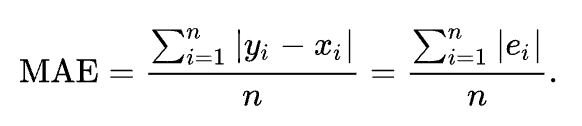

In [23]:
criterion = nn.L1Loss()
metric = nn.L1Loss()

#### Lets Use the Optimizer 

![About Gradient Descent](https://www.analyticsvidhya.com/blog/2022/07/gradient-descent-and-its-types/)
![About Optimizers](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/)

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #  0.003
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1) # learning rate decay 

#### Training the Model

In [25]:
def get_loss(model, s, p):
    e_out, dp_out, ds_out = model.forward((s, p))
        
    e_loss = criterion(e_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
    dp_loss = criterion(dp_out.view((-1, flat_payload_size)), p.view((-1, flat_payload_size)))
    ds_loss = criterion(ds_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
    
    loss = e_loss + dp_loss + ds_loss 
    
    return loss

def train_step(model, optimizer, s, p):
    temp_loss = 0.
    optimizer.zero_grad()

    loss = get_loss(model, s, p)

    loss.backward()
    optimizer.step()
    
    temp_loss += loss.item()
    
    return temp_loss

In [ ]:
epochs = 100

train_losses, val_losses = [], []
batch_size = 128
test_batch_size = 100

flat_source_size = SIZE_IMAGE * SIZE_IMAGE * 3
flat_payload_size = SIZE_IMAGE * SIZE_IMAGE
filename_saved = f'{PATH_DATA}/models/robotics_test.pt'
valid_loss_min = np.inf # this is to be able to load the validation loss

for epoch in tqdm(range(epochs)):
    model.train()
    train_loss = 0.
    total_batches = int(len(source_train) /batch_size) + 1
    for idx in range(total_batches):
        start = idx*batch_size
        end = start + batch_size
        indices1 = np.arange(start, end if end <= len(source_train) else end - (end%len(source_train)))
        indices2 = np.arange(start, end if end <= len(source_train) else end - (end%len(source_train)))
        np.random.shuffle(indices1)
        np.random.shuffle(indices2)
        
        s = source_train[indices1]
        p = payload_train[indices2]
        s, p = torch.from_numpy(s).float().to(device), torch.from_numpy(p).float().to(device)
        train_loss += train_step(model, optimizer, s, p)
    
    else:
        val_loss = 0.
        model.eval()
        val_batches = int(len(source_val) / test_batch_size) 
        with torch.no_grad():
            for idx in range(val_batches):
                s, p = source_val[idx*test_batch_size: (idx * test_batch_size) + test_batch_size], payload_val[idx*test_batch_size: (idx * test_batch_size) + test_batch_size]
                s, p = torch.from_numpy(s).float().to(device), torch.from_numpy(p).float().to(device)
                
                e_out, dp_out, ds_out = model.forward((s, p))

                e_loss = metric(e_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
                dp_loss = metric(dp_out.view((-1, flat_payload_size)), p.view((-1, flat_payload_size)))
                ds_loss = metric(ds_out.view((-1, flat_source_size)), s.view((-1, flat_source_size)))
                loss = e_loss + dp_loss + ds_loss
                
                val_loss += loss
            
            train_losses.append(train_loss / (total_batches * 2))
            val_losses.append(val_loss / val_batches)
            
            print('Epoch: {}\nTrain Loss: {}, Val Loss: {}'.format(epoch, train_losses[-1], val_losses[-1]))
        scheduler.step()
        if val_losses[-1] <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            val_losses[-1]))
            torch.save(model.state_dict(), filename_saved)
            valid_loss_min = val_losses[-1]

### Lets Test the Model 

Cargar modelo preentrenado con Pytorch

In [26]:
filename_saved = f'{PATH_DATA}/models/pretrained_model.pt'

def load_model(path_model):
  """
  Method to load the model
  """
  device = torch.device("mps")

  model = StegNet()
  model.load_state_dict(
    torch.load(path_model, map_location={'cuda:0': 'cpu'}))  # Choose whatever GPU device number you want
  model.to(device)
  return model


model = load_model(filename_saved)
model

StegNet(
  (encoder_payload_1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_21): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_4): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_source_41): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_payload_5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoder_s

In [28]:
# imports
import skimage
import numpy as np

# Imagenes para visualizar resultados
path_im_source = f'{PATH_DATA}/samples/source.png' # 
path_im_payload = f'{PATH_DATA}/samples/payload.jpeg' #Cambiar nombre

def image_to_tensor(path_image, convert="RGB", device="cpu"):
    image_array = np.array(open_image_and_resize(path_image, 64, 64).convert(convert)).astype(np.uint8)
    return torch.from_numpy(image_array).float().to(device)


def images_to_tensor(path_source, path_payload, device='cpu'): #todo nosotoros: cambiar método para llamar un open and resize 
    image_source_tensor = image_to_tensor(path_source, convert="RGB", device=device)
    image_payload_tensor = image_to_tensor(path_payload, convert="L", device=device)

    return image_source_tensor, image_payload_tensor


### ENCODING 

Lets try and encode our payload into our source

/var/folders/kd/z19g70497398jd_ysz4ytbxc0000gp/T/ipykernel_6683/40344773.py:13: RuntimeWarning: invalid value encountered in cast
  plt.imshow(numpy_tensor_encoded.astype('uint8'))


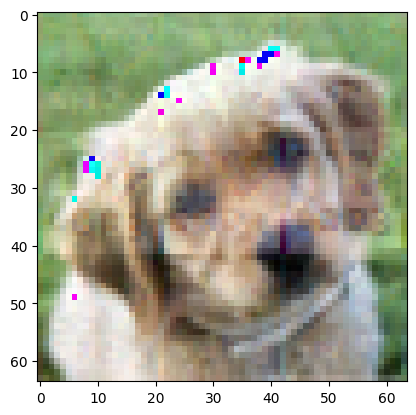

In [37]:
# encode images
def inference_encoder(path_source, path_payload,device="mps" ):
  im_source, im_payload = images_to_tensor(path_source, path_payload, device=device)
  with torch.no_grad():
    model.eval()
    encoded_image = model.predict_encoder(im_source, im_payload) 
  
  encoded_image = encoded_image.cpu()
  return encoded_image

tensor_result = inference_encoder(path_im_source, path_im_payload, device="mps")
numpy_tensor_encoded = tensor_result.view((-1, SIZE_IMAGE, SIZE_IMAGE, 3)).numpy()[0]
plt.imshow(numpy_tensor_encoded.astype('uint8'))

In [38]:
# save encoded image
from skimage.io import imsave, imread

path_im_encoded = f'{PATH_DATA}/samples/logo_encoded_result.tif'

imsave(path_im_encoded, numpy_tensor_encoded/255)
image_encoded = imread(path_im_encoded)
assert np.allclose(numpy_tensor_encoded, image_encoded*255) 

### Lets Test the Model 

We can test the model by passing in an image and a message. The model will then encode the message into the image and return the stego image.


/var/folders/kd/z19g70497398jd_ysz4ytbxc0000gp/T/ipykernel_6683/583488069.py:12: RuntimeWarning: invalid value encountered in cast
  decoded_payload_result = decoded_payload.view((-1, SIZE_IMAGE, SIZE_IMAGE)).numpy()[0].astype('uint8')


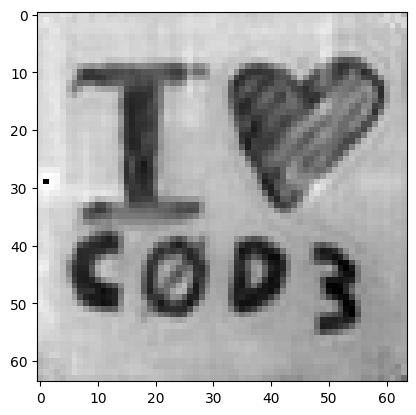

In [39]:
# image decoder 
def inference_decoder(path_image_to_decode, device='mps'):
  image_to_decode = imread(path_image_to_decode)
  image_to_decode = image_to_decode*255
  image_to_decode_tensor = torch.from_numpy(image_to_decode).float().to(device)

  with torch.no_grad():
      model.eval()
      decoded_payload = model.predict_decoder(image_to_decode_tensor)

  decoded_payload = decoded_payload.cpu()
  decoded_payload_result = decoded_payload.view((-1, SIZE_IMAGE, SIZE_IMAGE)).numpy()[0].astype('uint8') 

  return decoded_payload_result


decoded_image = inference_decoder(path_im_encoded, device="mps")
plt.imshow(decoded_image, cmap='gray')

## Lets see the results 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/vera/RoboticsClub/steganography/.venv/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['imread', 'log', 'imsave']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +
/var/folders/kd/z19g70497398jd_ysz4ytbxc0000gp/T/ipykernel_6683/2858041227.py:5: RuntimeWarning: invalid value encountered in cast
  plt.imshow(numpy_tensor_encoded.astype('uint8'))


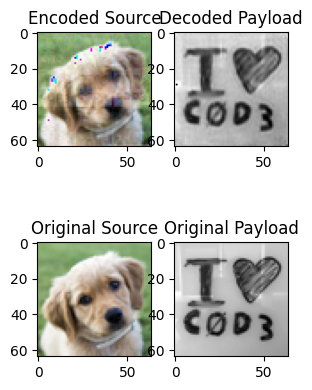

In [40]:
%pylab inline
plt.figure(figsize=(5,5))
plt.subplot(2, 3, 1)
plt.title('Encoded Source')
plt.imshow(numpy_tensor_encoded.astype('uint8'))
plt.subplot(2, 3, 2)
plt.title('Decoded Payload')
plt.imshow(decoded_image, cmap='gray')

image_source_numpy = np.array(open_image_and_resize(path_im_source, 64, 64).convert('RGB')).astype(np.uint8)
image_payload_numpy = np.array(open_image_and_resize(path_im_payload, 64, 64).convert('L')).astype(np.uint8)

plt.subplot(2, 3, 4)
plt.title('Original Source')
plt.imshow(image_source_numpy)
plt.subplot(2, 3, 5)
plt.title('Original Payload')
plt.imshow(image_payload_numpy, cmap='gray')

plt.show()